# Papers:

https://www.semanticscholar.org/paper/Analysis-of-focus-measure-operators-for-Pertuz-Puig/8c675bf5b542b98bf81dcf70bd869ab52ab8aae9?p2df
https://pyimagesearch.com/2020/06/15/opencv-fast-fourier-transform-fft-for-blur-detection-in-images-and-video-streams/

### Import modules and image loading

In [22]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load an image from the 'images' folder
image_path = os.path.join('images', 'soapbubbles.png')

# Read the image in grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

## FTT: Fast fourier transformation

The fast Fourier transform (FFT) is an algorithm that computes the discrete Fourier transform (DFT) of a sequence. In our case we are dealing with a 2D signal, the image. In this process our signal in the space domain is transformed to its representation in the frequency domain.

Since images are always represented in the discrete domain we cannot use the original Fourier Transform but we have to use instead the Discrete Fourier Transform (DFT).

- **Fourier Transform**:

  $ F(u, v) = \iint_{-\infty}^{\infty} f(x, y) e^{-j2\pi(ux + vy)} \, dx \, dy $

- **Discrete Fourier Transform**:

  $ F(u, v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x, y) e^{-j2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)} $


For calculating the FFT we can simply use the function `cv2.dft()`.

Shape of the result: (256, 256)


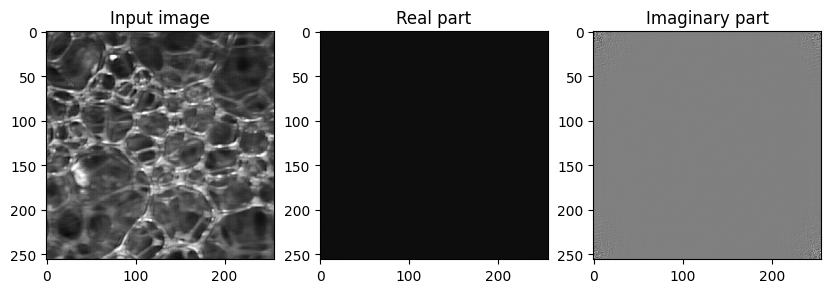

In [26]:
ftt = np.fft.fft2(image)
print(f"Shape of the result: {ftt.shape}")

# plot real and imaginary parts of the image
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Input image')
plt.subplot(132)
plt.imshow(np.real(ftt), cmap='gray')
plt.title('Real part')
plt.subplot(133)
plt.imshow(np.imag(ftt), cmap='gray')
plt.title('Imaginary part')
plt.show()

### Shift the zero-frequency component to the center of the spectrum

The zero-frequency component is located at the top-left corner of the FFT image. We can shift it to the center of the image by using the function `np.fft.fftshift()`. This is to make the FFT image more clear and easier to analyze.

To do that we can use the function `np.fft.fftshift()`.

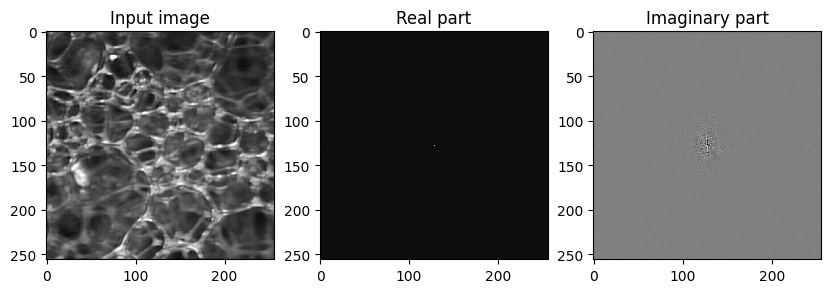

In [28]:
ftts = np.fft.fftshift(ftt)

# plot real and imaginary parts of the image
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Input image')
plt.subplot(132)
plt.imshow(np.real(ftts), cmap='gray')
plt.title('Real part')
plt.subplot(133)
plt.imshow(np.imag(ftts), cmap='gray')
plt.title('Imaginary part')
plt.show()


# Magnitude calculation

Text(0.5, 1.0, 'Magnitude spectrum')

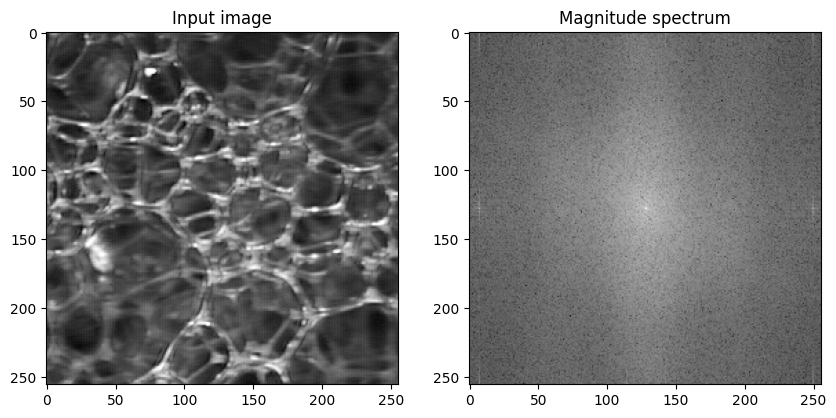

In [29]:
magnitude_spectrum = 20 * np.log(cv2.magnitude(np.real(ftts), np.imag(ftts)))

# plot real and imaginary parts of the image
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Input image')
plt.subplot(122)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude spectrum')


## Removing low frequencies

- Blurred images generally lack sharp edges and fine details, which correspond to high-frequency components in the frequency domain. When an image is blurred, the high-frequency components are attenuated.

- Details and edges in images are represented by high-frequency components. By analyzing these components, you can assess the presence and strength of edges and textures


Apply a high pass filter to the FFT image to remove the low frequencies.
This is done by masking the low frequencies with a rectangular window of size proportional to the size of the image.


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_4248/2951680135.py:14: RuntimeWarning: divide by zero encountered in log
  filtered_mag_spectrum = 20 * np.log(cv2.magnitude(np.real(ftt_filtered), np.imag(ftt_filtered)))


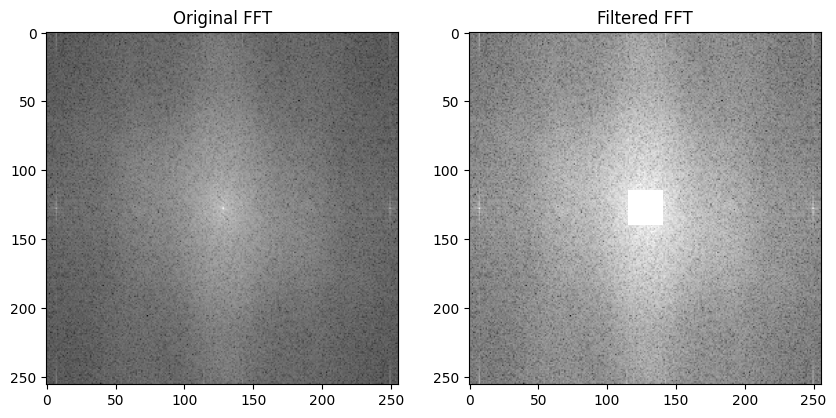

In [37]:
# create a mask first, center square is 1, remaining all zeros
rows, cols = image.shape

# 10% of the rows and cols
size = int(max([rows, cols]) * 0.05)
high_pass_mask = np.ones(image.shape)
high_pass_mask[
    rows // 2 - size : rows // 2 + size,
    cols // 2 - size : cols // 2 + size
] = 0

# apply the mask to the fft obtained in the previous section and display the results
ftt_filtered = ftts * high_pass_mask
filtered_mag_spectrum = 20 * np.log(cv2.magnitude(np.real(ftt_filtered), np.imag(ftt_filtered)))

# plot filtered and unfiltered images
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Original FFT')
plt.subplot(122)
plt.imshow(filtered_mag_spectrum, cmap='gray')
plt.title('Filtered FFT')
plt.show()